In [1]:
ROOT_FOLDER = '/root/jupyter_home/keras_Object_Detection'

In [2]:
cd $ROOT_FOLDER

/root/jupyter_home/keras_Object_Detection


In [3]:
!mkdir -p Numberdevkit
!mkdir -p Numberdevkit/Number
!mkdir -p Numberdevkit/Number/JPEGImages
!mkdir -p Numberdevkit/Number/Annotations
!mkdir -p Numberdevkit/Number/ImageSets
!mkdir -p Numberdevkit/Number/ImageSets/Main

In [4]:
cd $ROOT_FOLDER/Numberdevkit/Number/JPEGImages

/root/jupyter_home/keras_Object_Detection/Numberdevkit/Number/JPEGImages


In [7]:
cp /root/jupyter_home/YOLOv8_Object_Detection/number_train.zip .

In [ ]:
!unzip number_train.zip

In [10]:
!rm number_train.zip

In [13]:
cd $ROOT_FOLDER/Numberdevkit/Number

/root/jupyter_home/keras_Object_Detection/Numberdevkit/Number


In [14]:
cp /root/jupyter_home/YOLOv8_Object_Detection/number_data.csv .

In [15]:
import pandas as pd
import os
import xml.etree.ElementTree as ET
from PIL import Image

# CSV 불러오기
df = pd.read_csv("./number_data.csv")

# XML 저장할 경로
output_dir = "./Annotations"
os.makedirs(output_dir, exist_ok=True)

# 이미지 경로 (이미지 크기를 알기 위해 필요)
image_dir = "./JPEGImages"  # 이미지가 있는 폴더

# 파일별로 그룹화
grouped = df.groupby("filename")

for filename, group in grouped:
    image_path = os.path.join(image_dir, filename)
    
    # 이미지 열어서 크기 얻기
    with Image.open(image_path) as img:
        img_width, img_height = img.size
    
    annotation = ET.Element("annotation")
    
    ET.SubElement(annotation, "folder").text = os.path.basename(image_dir)
    ET.SubElement(annotation, "filename").text = filename
    
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(img_width)
    ET.SubElement(size, "height").text = str(img_height)
    ET.SubElement(size, "depth").text = "3"  # RGB assumed

    for _, row in group.iterrows():
        obj = ET.SubElement(annotation, "object")
        ET.SubElement(obj, "name").text = str(row['label'])
        ET.SubElement(obj, "pose").text = "Unspecified"
        ET.SubElement(obj, "truncated").text = "0"
        ET.SubElement(obj, "difficult").text = "0"

        bndbox = ET.SubElement(obj, "bndbox")
        xmin = int(row['left'])
        ymin = int(row['top'])
        xmax = xmin + int(row['width'])
        ymax = ymin + int(row['height'])

        ET.SubElement(bndbox, "xmin").text = str(xmin)
        ET.SubElement(bndbox, "ymin").text = str(ymin)
        ET.SubElement(bndbox, "xmax").text = str(xmax)
        ET.SubElement(bndbox, "ymax").text = str(ymax)

    # XML 저장
    tree = ET.ElementTree(annotation)
    xml_path = os.path.join(output_dir, filename.replace('.png', '.xml').replace('.jpg', '.xml'))
    tree.write(xml_path)


In [16]:
import os
import random

# 이미지 ID 목록 (확장자 제거)
image_dir = "./JPEGImages"  # or 'images'
image_ids = [f.split('.')[0] for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

# 셔플하고 분할
random.seed(42)
random.shuffle(image_ids)

split_ratio = 0.8
split_idx = int(len(image_ids) * split_ratio)
train_ids = image_ids[:split_idx]
val_ids = image_ids[split_idx:]

# 저장
with open("./ImageSets/Main/train.txt", "w") as f:
    f.write("\n".join(train_ids))

with open("./ImageSets/Main/val.txt", "w") as f:
    f.write("\n".join(val_ids))


In [19]:
import os
import tensorflow as tf
import xml.etree.ElementTree as ET

NUM_CLASSES = [
    "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"
]
class_name_to_id = {name: i for i, name in enumerate(NUM_CLASSES)}

def parse_num_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    bboxes = []
    labels = []

    for obj in root.findall("object"):
        name = obj.find("name").text
        label = class_name_to_id[name]

        bbox = obj.find("bndbox")
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))

        bboxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return filename, width, height, bboxes, labels

def create_tf_example(image_path, xml_path):
    filename, width, height, bboxes, labels = parse_num_xml(xml_path)

    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_image = fid.read()

    xmins = [box[0] / width for box in bboxes]
    ymins = [box[1] / height for box in bboxes]
    xmaxs = [box[2] / width for box in bboxes]
    ymaxs = [box[3] / height for box in bboxes]

    classes_text = [NUM_CLASSES[label].encode('utf8') for label in labels]
    classes = labels

    feature = {
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf8')])),
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example

def generate_tfrecord(num_dir, split_txt, output_path):
    annotation_dir = os.path.join(num_dir, 'Annotations')
    image_dir = os.path.join(num_dir, 'JPEGImages')

    with tf.io.TFRecordWriter(output_path) as writer:
        with open(split_txt, 'r') as f:
            lines = f.read().strip().splitlines()

        for img_id in lines:
            xml_path = os.path.join(annotation_dir, f"{img_id}.xml")
            img_path = os.path.join(image_dir, f"{img_id}.png")

            if os.path.exists(xml_path) and os.path.exists(img_path):
                example = create_tf_example(img_path, xml_path)
                writer.write(example.SerializeToString())

NUM_ROOT_DIR = '/root/jupyter_home/keras_Object_Detection'

# 실행
generate_tfrecord(
    num_dir=NUM_ROOT_DIR + "/Numberdevkit/Number",
    split_txt=NUM_ROOT_DIR + "/Numberdevkit/Number/ImageSets/Main/train.txt",
    output_path=NUM_ROOT_DIR + "/number_train.tfrecord"
)

generate_tfrecord(
    num_dir=NUM_ROOT_DIR + "/Numberdevkit/Number",
    split_txt=NUM_ROOT_DIR + "/Numberdevkit/Number/ImageSets/Main/val.txt",
    output_path=NUM_ROOT_DIR + "/number_val.tfrecord"
)

In [20]:
cd $ROOT_FOLDER

/root/jupyter_home/keras_Object_Detection


In [21]:
IMAGE_SIZE = 512

def parse_tfrecord(example):
    features = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    parsed = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(parsed['image/encoded'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    xmins = tf.sparse.to_dense(parsed['image/object/bbox/xmin'])
    ymins = tf.sparse.to_dense(parsed['image/object/bbox/ymin'])
    xmaxs = tf.sparse.to_dense(parsed['image/object/bbox/xmax'])
    ymaxs = tf.sparse.to_dense(parsed['image/object/bbox/ymax'])
    labels = tf.sparse.to_dense(parsed['image/object/class/label'])

    boxes = tf.stack([xmins, ymins, xmaxs, ymaxs], axis=-1)

    return {
        "images": image,
        "bounding_boxes": {
            "boxes": boxes,
            "classes": tf.cast(labels, tf.int32),
        }
    }

def load_dataset(tfrecord_path, batch_size=8):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord, 
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    # padded_batch 필수
    dataset = dataset.shuffle(1000).padded_batch(
        batch_size,
        padded_shapes={
            "images": [IMAGE_SIZE, IMAGE_SIZE, 3],
            "bounding_boxes": {
                "boxes": [None, 4],
                "classes": [None]
            }
        },
        drop_remainder=True
    ).prefetch(tf.data.AUTOTUNE)

    return dataset


train_ds = load_dataset("./number_train.tfrecord", 
                        batch_size=8)

val_ds = load_dataset("./number_val.tfrecord", 
                        batch_size=8)

In [31]:
from keras_cv.models import RetinaNet
model = RetinaNet.from_preset(
    'resnet50',
    bounding_box_format='xyxy',
    num_classes=10
)

In [32]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4),
              classification_loss='focal',
              box_loss='smoothl1')

In [ ]:
model.fit(
    train_ds,
    epochs=10,
    verbose=1
)

1/1 [==============================] - 5s 5s/step


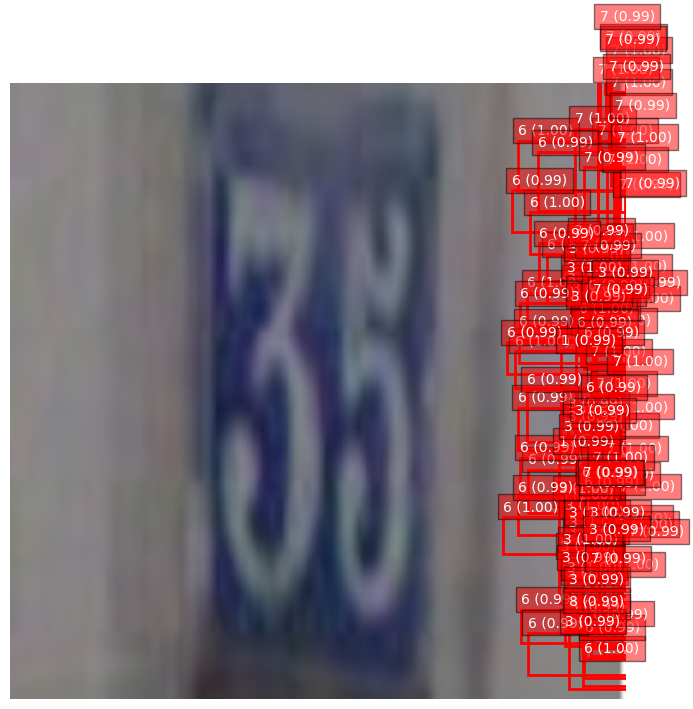

In [47]:
# 예측 및 시각화
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

NUM_CLASSES = [
    "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"
]

def visualize_prediction(image, boxes, classes, scores, threshold=0.3):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    for box, cls, score in zip(boxes, classes, scores):
        if score < threshold:
            continue
        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), w, h,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        class_name = NUM_CLASSES[int(cls)]
        ax.text(
            x1, y1 - 5,
            f"{class_name} ({score:.2f})",
            fontsize=10,
            color="white",
            bbox=dict(facecolor="red", alpha=0.5)
        )

    plt.axis("off")
    plt.show()

# 예측 결과 (batched)
sample = next(iter(val_ds))
images, y_true = sample["images"], sample["bounding_boxes"]

# 예측 (batched)
y_pred = model.predict(images)

# 첫 번째 이미지만 시각화
image = images[0].numpy()
# 이미지 크기에 맞게 scale (RetinaNet은 512x512로 resize됨)
image = np.clip(image * 255, 0, 255).astype("uint8")

boxes = y_pred["boxes"][0]
classes = y_pred["classes"][0]
scores = y_pred["confidence"][0]

visualize_prediction(image, boxes, classes, scores, threshold=0.3)